# CSG Result Analysis


## Introduction

This notebook is a breakdown of results gathered from running tests on the implementation of the Combinatorial Geometry method in the OpenRT library. The following sections breakdown the way the tests were conducted and also the flow of the rest of this notebook.


### The 3 Operations

By definition, constructive solid geometry is a method which allows to construct complex geometries using primitive operation and boolean set operations (Union, Difference, Intersection). Therefore, every test requires us to test each of these operations on the same exact load. In theory, the operation itself shouldn't have a drastic impact on the performance of the algorithm.

### The 3 Algorithms

There are 3 variants of the CSG method implemented in OpenRT. The first is the naive and brute force implementation which we refer to as _NaiCSG_. The second is a variant that uses a Binary Space Partition tree in order to solve the visible surface problem but still naivly finds intersections inside the combinatorial geometry, which we will refer to as _BinCSG_. Lastly, we'll introduce our optimized algorithm which uses a binary space partition tree on the outside (solving the visible surface problem) and also inside each composite geometry in order to direct the rays towards the correct geometries, which we will refer to as _OptiCSG_. Every algorithm is checked for each operation - meaning a total of 9 simulations are conducted per test type.

### The 3 Tests

We conduct 3 main tests. First, we check how the rendering time develops with respect to the complexity of the geometry. In this case, the complexity of the geometry is the number of polygons in the sphere meshes.
The second tests are based on the reaction of the different algorithms to a different number of nested geometries while maitaining a relevantly similar viewport fill rate (how much of the image actually contains geometries). The third test gives us an idea of how the spatial distribution of the scene (how much of the viewport is actually filled) affects the times for each of the algorithms. This helps us grasp how much the view port fill percentage affects each of these algorithms individually; therefore, either confirming or denying our hypothesis.

### Notebook Breakdown

There are a total of 4 sections (the first being this introduction). Section 2 focuses entirely on extracting data for each alogrithm and only comparing the time of the different operations. Section 3 is focused on processing the data and comparing the mean time of each algorithm to the other. The last section works on modeling the time complexities to close representations and finally drawing conclusion on the performance.  

### Hardware Specifications

All tests were ran on a Macbook Pro 13" 2017

- **Processor:** 2,3 GHz Dual-Core Intel Core i5
- **Memory:** 8 GB 2133 MHz LPDDR3
- **Graphics Card:** Intel Iris Plus Graphics 640 1536 MB

## Geometry Complexity & Rendering Times

### NaiCSG


The naive algorithm essentially brute-forces its way through the hidden surface problem. For each ray, it iterates over all geometries in the scene and picks the closest intersection. Therefore if a scene contains 100 geometries and we have a 2000x2000px image (not a lot by today standards). A total of **400.000.000** intersections will be checked before the image is finally rendered. 

In [1]:
!apt-get update && apt-get install -y python3-opencv
!pip install opencv-python==4.5.1.48

Get:60 http://deb.debian.org/debian buster/main amd64 libarpack2 amd64 3.7.0-2 [102 kB]
Get:61 http://deb.debian.org/debian buster/main amd64 libsuperlu5 amd64 5.2.1+dfsg1-4 [161 kB]
Get:62 http://deb.debian.org/debian buster/main amd64 libarmadillo9 amd64 1:9.200.7+dfsg-1 [88.6 kB]
Get:63 http://deb.debian.org/debian buster/main amd64 libatk-bridge2.0-0 amd64 2.30.0-5 [61.6 kB]
Get:64 http://deb.debian.org/debian buster/main amd64 libva-drm2 amd64 2.4.0-1 [16.6 kB]
Get:65 http://deb.debian.org/debian buster/main amd64 libva-x11-2 amd64 2.4.0-1 [21.3 kB]
Get:66 http://deb.debian.org/debian buster/main amd64 libvdpau1 amd64 1.1.1-10 [42.0 kB]
Get:67 http://deb.debian.org/debian buster/main amd64 libavutil56 amd64 7:4.1.6-1~deb10u1 [237 kB]
Get:68 http://deb.debian.org/debian buster/main amd64 libcodec2-0.8.1 amd64 0.8.1-2 [233 kB]
Get:69 http://deb.debian.org/debian buster/main amd64 libcrystalhd3 amd64 1:0.0~git20110715.fdd2f19-13 [45.9 kB]
Get:70 http://deb.debian.org/debian buster/ma

In [2]:
# setting up notebook all modules
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import cv2
from scipy.interpolate import make_interp_spline, BSpline
from functools import reduce


saveFig = False

In [3]:
nai_intersection = pd.read_csv('n_primitives_tests/tests_pdp_intersection.txt')
nai_union = pd.read_csv('n_primitives_tests/tests_pdp_union.txt')
nai_difference = pd.read_csv('n_primitives_tests/tests_pdp_difference.txt')

In [4]:
df_normal = pd.concat([nai_intersection, nai_union, nai_difference], axis=1)
df_normal.columns = ["Triangle Number", "Intersection Time", "tris2", "Union Time", "tris3", "Difference Time"]
df_normal = df_normal.drop(columns=['tris2', 'tris3'])
col = df_normal.loc[: , "Intersection Time":"Difference Time"]
df_normal['NaiCSG Mean Time'] = col.mean(axis=1)

In [5]:
df_normal

,Triangle Number,Intersection Time,Union Time,Difference Time,NaiCSG Mean Time
0,56,9584,10005,10244,9.944333e+03
1,96,14842,13504,17231,1.519233e+04
2,108,19609,15103,27751,2.082100e+04
3,160,23874,21834,34702,2.680333e+04
4,176,24185,23850,34382,2.747233e+04
...,...,...,...,...,...
84,16016,2358169,2185245,2616391,2.386602e+06
85,16560,2325892,2249876,2661334,2.412367e+06
86,16740,2468460,2281268,2728314,2.492681e+06
87,17296,2827311,2477078,2849404,2.717931e+06


#### NaiCSG 3 Operations Plot 

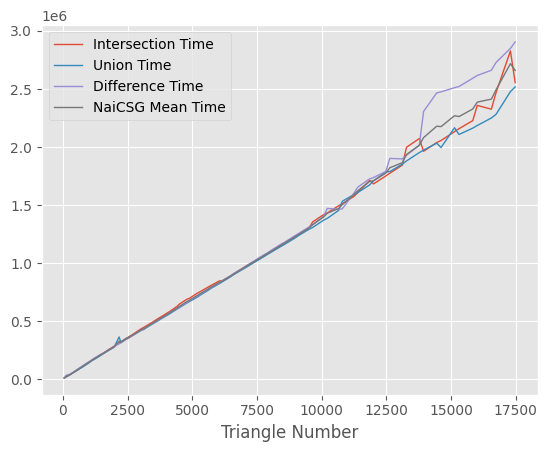

In [6]:
df_normal.plot(x ='Triangle Number', y=['Intersection Time', 'Union Time', 'Difference Time', 'NaiCSG Mean Time'], kind = 'line', lw=1)
plt.show()
if saveFig:
    plt.savefig('NaiCSG-OPS.png')

# step size in triangles grow exponentiall; therefore the bar chart shows different results than the scaled one below here.

### BinCSG

In [7]:
bsp_intersection = pd.read_csv('n_primitives_tests/tests_bsp_pdp_intersection.txt')
bsp_union = pd.read_csv('n_primitives_tests/tests_bsp_pdp_union.txt')
bsp_difference = pd.read_csv('n_primitives_tests/tests_bsp_pdp_difference.txt')

In [8]:
df_bsp = pd.concat([bsp_intersection, bsp_union, bsp_difference], axis=1)
df_bsp.columns = ["Triangle Number", "Intersection Time", "tris2", "Union Time", "tris3", "Difference Time"]
df_bsp = df_bsp.drop(columns=['tris2', 'tris3'])
col2 = df_bsp.loc[: , "Intersection Time":"Difference Time"]
df_bsp['BinCSG Mean Time'] = col2.mean(axis=1)

In [9]:
df_bsp

,Triangle Number,Intersection Time,Union Time,Difference Time,BinCSG Mean Time
0,56,787,1269,1208,1.088000e+03
1,96,1410,2160,4186,2.585333e+03
2,108,1531,2332,3368,2.410333e+03
3,160,1909,3170,5206,3.428333e+03
4,176,2036,3380,3362,2.926000e+03
...,...,...,...,...,...
193,79200,941104,1541728,1231117,1.237983e+06
194,79596,912189,1549889,1145179,1.202419e+06
195,80800,927021,1662735,1149373,1.246376e+06
196,81200,939500,1622445,1167704,1.243216e+06


#### BinCSG 3 Operations Plot 

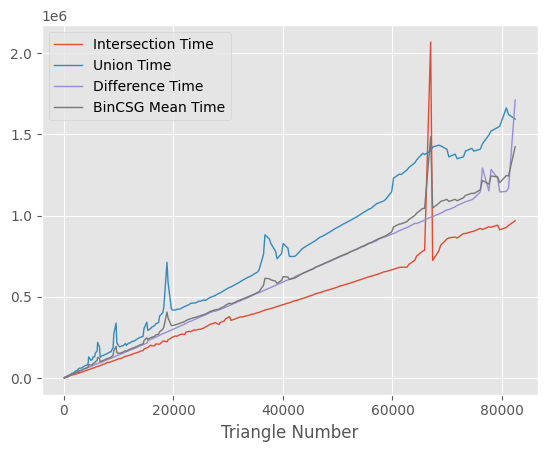

In [10]:
df_bsp.plot(x ='Triangle Number', y=['Intersection Time', 'Union Time', 'Difference Time', 'BinCSG Mean Time'], kind = 'line', lw=1)
plt.show()
if saveFig:
    plt.savefig('BinCSG-OPS.png')

### OptimCSG

In [11]:
optim_intersection = pd.read_csv('n_primitives_tests/tests_bsp_optim_intersection.txt')
optim_union = pd.read_csv('n_primitives_tests/tests_bsp_optim_union.txt')
optim_difference = pd.read_csv('n_primitives_tests/tests_bsp_optim_difference.txt')


In [12]:
df_optim = pd.concat([optim_intersection, optim_union, optim_difference], axis=1)
df_optim.columns = ["Triangle Number", "Intersection Time", "tris2", "Union Time", "tris3", "Difference Time"]
df_optim = df_optim.drop(columns=['tris2', 'tris3'])
col3 = df_optim.loc[: , "Intersection Time":"Difference Time"]
df_optim['OptiCSG Mean Time'] = col3.mean(axis=1)

In [13]:
df_optim

,Triangle Number,Intersection Time,Union Time,Difference Time,OptiCSG Mean Time
0,56,672,763,948,794.333333
1,96,840,993,1338,1057.000000
2,108,849,976,1443,1089.333333
3,160,858,1045,1951,1284.666667
4,176,825,984,1863,1224.000000
...,...,...,...,...,...
194,79596,1415,1692,2816,1974.333333
195,80800,1452,1737,2937,2042.000000
196,81200,1433,1719,2853,2001.666667
197,82416,1351,1609,2661,1873.666667


#### OptimCSG 2 Operations Plot

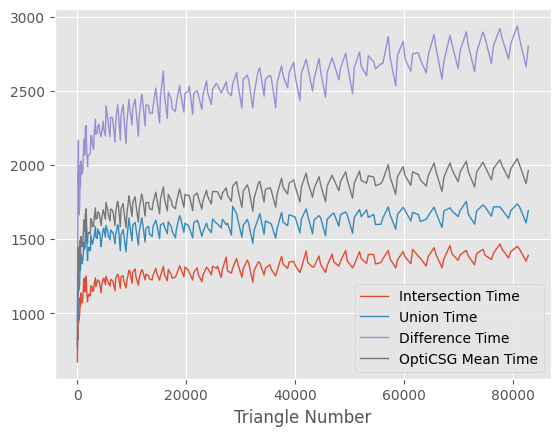

In [14]:
df_optim.plot(x ='Triangle Number', y=['Intersection Time', 'Union Time', 'Difference Time', 'OptiCSG Mean Time'], kind = 'line', lw=1)
plt.show()
if saveFig:
    plt.savefig('OptimCSG-OPS.png')

In [15]:
df_comp = pd.concat([df_normal["Triangle Number"], df_normal["NaiCSG Mean Time"], df_bsp[0:len(df_normal.index)]["BinCSG Mean Time"], df_optim[0:len(df_normal.index)]["OptiCSG Mean Time"]], axis=1)

df_comp

,Triangle Number,NaiCSG Mean Time,BinCSG Mean Time,OptiCSG Mean Time
0,56,9.944333e+03,1088.000000,794.333333
1,96,1.519233e+04,2585.333333,1057.000000
2,108,2.082100e+04,2410.333333,1089.333333
3,160,2.680333e+04,3428.333333,1284.666667
4,176,2.747233e+04,2926.000000,1224.000000
...,...,...,...,...
84,16016,2.386602e+06,250487.666667,1775.333333
85,16560,2.412367e+06,256954.666667,1689.333333
86,16740,2.492681e+06,264765.666667,1801.333333
87,17296,2.717931e+06,270377.000000,1760.000000


### Final Plots

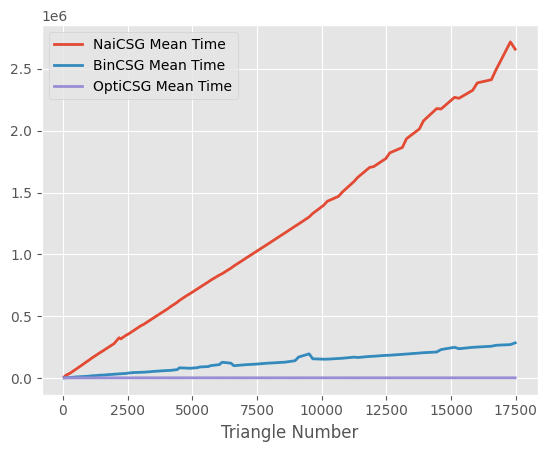

In [16]:
# Performance of all versions
df_comp.plot(x="Triangle Number", y=["NaiCSG Mean Time", "BinCSG Mean Time", "OptiCSG Mean Time"], kind="line", lw=2)
plt.show()
if saveFig:
    plt.savefig('Performance-3OPS.png')

In [17]:
mean_time_nai = df_comp["NaiCSG Mean Time"].mean()
mean_time_bin = df_comp["BinCSG Mean Time"].mean()
mean_time_opti = df_comp["OptiCSG Mean Time"].mean()

print("Mean time for test per operation:")
print("NaiCSG: " + str(mean_time_nai))
print("BinCSG: " + str(mean_time_bin))
print("OptiCSG: " + str(mean_time_opti))

speedup_nai_bin = mean_time_nai / mean_time_bin
speedup_nai_opti = mean_time_nai / mean_time_opti
speedup_bin_opti = mean_time_bin / mean_time_opti

print("\nSpeedup per operation:")
print("NaiCSG/BinCSG: " + str(speedup_nai_bin))
print("NaiCSG/OptiCSG: " + str(speedup_nai_opti))
print("BinCSG/OptiCSG: " + str(speedup_bin_opti))

Mean time for test per operation:
NaiCSG: 895725.6479400748
BinCSG: 97903.80149812733
OptiCSG: 1603.0374531835207

Speedup per operation:
NaiCSG/BinCSG: 9.149038487103159
NaiCSG/OptiCSG: 558.7677606416656
BinCSG/OptiCSG: 61.073932679300285


## Number of Nests


In [18]:
nest_nai = pd.read_csv('n_nests_tests/nesting_base_union.txt', header=None)
nest_optim = pd.read_csv('n_nests_tests/nesting_optim_union.txt', header=None)
nest_bin = pd.read_csv('n_nests_tests/nesting_bin_union.txt', header=None)
nest_viewport = pd.read_csv('n_nests_tests/nest_to_viewport.txt', header=None)

In [19]:
df_nest = pd.concat([nest_nai, nest_optim, nest_bin, nest_viewport], axis=1)
df_nest.columns = ["Triangle Number", "Number of Nests", "NaiCSG Time", "tris2", "nests2", "OptiCSG Time", "tris3", "nests3", "BinCSG Time", "nests4", "Viewport Fill"]
df_nest = df_nest.drop(columns=['tris2', 'nests2', 'tris3', 'nests3', 'nests4'])
mean_viewport_fill = df_nest['Viewport Fill'].mean()

print("Mean viewport fill")
print(mean_viewport_fill)

Mean viewport fill
71.62352430555556


In [20]:
df_nest

,Triangle Number,Number of Nests,NaiCSG Time,OptiCSG Time,BinCSG Time,Viewport Fill
0,1584,1,237058,4643,120359,73.893750
1,2112,2,325202,6850,166538,71.104427
2,2640,3,381395,7448,253581,68.207335
3,3168,4,455960,8604,272963,69.424826
4,3696,5,529122,9709,285720,70.639583
5,4224,6,599498,11480,298418,70.996875
6,4752,7,674182,12048,389363,69.498872
7,5280,8,758413,11278,391564,70.820095
8,5808,9,826069,12916,391875,72.025998
9,6336,10,899317,13431,397416,72.565755


### Final Plot

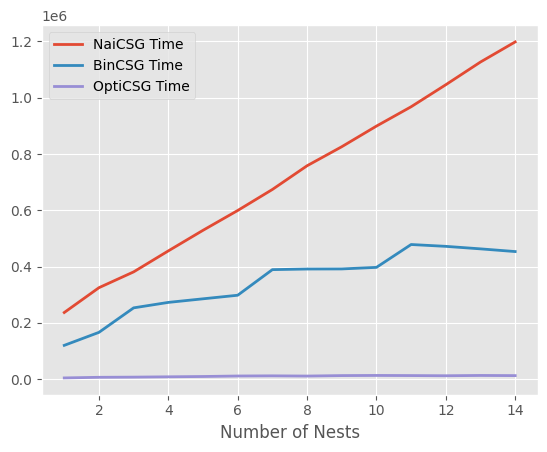

In [21]:
# Render time with respect to increases in the number of nests

df_nest.plot(x ='Number of Nests', y=['NaiCSG Time', 'BinCSG Time', 'OptiCSG Time'], kind = 'line', lw=2)
if saveFig:
    plt.savefig('nest-performance.png')
plt.show()

In [22]:
df_nest.plot(x ='Number of Nests', y=['OptiCSG Time'], kind = 'line', lw=2†)
if saveFig:
    plt.savefig('nest-performance.png')
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-22-ee2f5fcae700>, line 1)

## View Port Tests

In [ ]:
## First get the view port rates. These are the same across all operations so they should remain the same.
n_step = []
n_viewPort = []

for i in range(1, 21, 1):
    n_step.append(i)
    img = cv2.imread('view_port_renders/bin_port_union_' + str(i - 1) + '.png', cv2.IMREAD_GRAYSCALE)
    n_pixels = img.size
    n_white_pix = np.sum(img == 255)
    n_rate = (n_pixels - n_white_pix)/n_pixels * 100
    n_viewPort.append(n_rate)

data_tuples = list(zip(n_step,n_viewPort))
generic_rate = pd.DataFrame(data_tuples, columns=['Step','Viewport Fill Rate'])

In [ ]:
viewport_1 = pd.read_csv('viewport_tests/viewport_bin_union.txt', header=None)
viewport_1.columns = ["tris1", "step2", "BinCSG Time"]
viewport_1 = viewport_1.drop(columns=['tris1', 'step2'])

viewport_2 = pd.read_csv('viewport_tests/viewport_optim_union.txt', header=None)
viewport_2.columns = ["tris1", "step2", "OptiCSG Time"]
viewport_2 = viewport_2.drop(columns=['tris1', 'step2'])

viewport_3 = pd.read_csv('viewport_tests/viewport_base_union.txt', header=None)
viewport_3.columns = ["tris1", "step2", "NaiCSG Time"]
viewport_3 = viewport_3.drop(columns=['tris1', 'step2'])

df_viewport = pd.concat([generic_rate, viewport_1, viewport_2, viewport_3], axis=1)

In [ ]:
df_viewport

,Step,Viewport Fill Rate,BinCSG Time,OptiCSG Time,NaiCSG Time
0,1,0.143620,754,478,140108
1,2,0.578212,1746,586,143941
2,3,1.302648,3258,816,146766
3,4,2.322222,5684,1173,149234
4,5,3.642231,9215,1595,151668
5,6,5.270530,13591,2213,154006
6,7,7.211372,18246,3233,155492
7,8,9.470833,24391,5283,157720
8,9,12.062023,31784,5768,160388
9,10,14.992622,40582,6575,161123


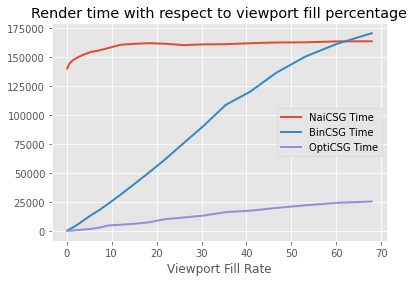

In [ ]:
subplot = df_viewport.plot(x ='Viewport Fill Rate', y=['NaiCSG Time', 'BinCSG Time', 'OptiCSG Time'], lw=2)
plt.title("Render time with respect to viewport fill percentage")
if saveFig:
    plt.savefig('viewport-performance.png')
plt.show()

In [ ]:
df_viewport

,Step,Viewport Fill Rate,BinCSG Time,OptiCSG Time,NaiCSG Time
0,1,0.143620,754,478,140108
1,2,0.578212,1746,586,143941
2,3,1.302648,3258,816,146766
3,4,2.322222,5684,1173,149234
4,5,3.642231,9215,1595,151668
5,6,5.270530,13591,2213,154006
6,7,7.211372,18246,3233,155492
7,8,9.470833,24391,5283,157720
8,9,12.062023,31784,5768,160388
9,10,14.992622,40582,6575,161123


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d2adc30-53a1-4bf1-8670-5f0dd5b807d5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>